# Using Transfer Learning by Pre-trained InceptionV3
## Load Libraries

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, DirectoryIterator
from tensorflow.keras.optimizers import SGD
import numpy as np
from tqdm import tqdm
import cv2

In [2]:
import sys
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print(sys.version)
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11913270484867016112
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6932588160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1229163619714974388
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
]
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
2.4.1


In [3]:
pretrained_model = InceptionV3(include_top=False)

# Freeze all feature extracting layers
for layers in pretrained_model.layers:
    layers.trainable = False
pretrained_model.summary()

67[0][0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, None, None, 1 147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, None, None, 1 576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, None, None, 1 576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, None, None, 1 576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, None, None, 1 576         conv2d_69[0][0]      

## Add Fully Connected Layer

In [4]:
flat1 = GlobalAveragePooling2D()(pretrained_model.output)
class1 = Dense(1024, activation='relu', name = 'dense')(flat1)
output = Dense(10, activation='softmax', name = 'output')(class1)
new_model = Model(inputs=pretrained_model.inputs, outputs=output)
new_model.summary()

              
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, None, None, 1 576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, None, None, 1 576         conv2d_69[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, None, None, 1 0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, None, None, 1 0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_68 (Activation)      (None, None, None, 1 0           batch_normalization_68[0][0] 

In [5]:
new_model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

# Preparing Data

In [6]:
data_dir = 'animal-10/raw-img'
dirs = os.listdir(data_dir)
X, y = [], []
for subdir in dirs:
    folder_dir = os.path.join(data_dir, subdir)
    for img in tqdm(os.listdir(folder_dir)):
        label = subdir
        path = os.path.join(folder_dir, img)
        X.append(path)
        y.append(str(label))


100%|██████████| 1862/1862 [00:00<00:00, 232850.15it/s]


In [7]:
img_height, img_width = 299, 299
batch_size = 32
generator = ImageDataGenerator(
    validation_split=0.33,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = generator.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training') # set as training data

validation_generator = generator.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation') # set as validation data


Found 17546 images belonging to 10 classes.
Found 8633 images belonging to 10 classes.


## Re-Training

In [8]:
history = new_model.fit(train_generator, epochs=5, validation_data=validation_generator)
history

Epoch 1/5
549/549 [==============================] - 424s 759ms/step - loss: 0.3424 - accuracy: 0.9057 - val_loss: 0.1260 - val_accuracy: 0.9637
Epoch 2/5
549/549 [==============================] - 414s 755ms/step - loss: 0.1128 - accuracy: 0.9666 - val_loss: 0.1251 - val_accuracy: 0.9643
Epoch 3/5
549/549 [==============================] - 401s 730ms/step - loss: 0.0902 - accuracy: 0.9726 - val_loss: 0.1265 - val_accuracy: 0.9651
Epoch 4/5
549/549 [==============================] - 394s 718ms/step - loss: 0.0830 - accuracy: 0.9747 - val_loss: 0.1260 - val_accuracy: 0.9708
Epoch 5/5
549/549 [==============================] - 395s 720ms/step - loss: 0.0775 - accuracy: 0.9765 - val_loss: 0.1129 - val_accuracy: 0.9691


In [9]:
new_model.save('model.h5')

## Visualization

<AxesSubplot:>

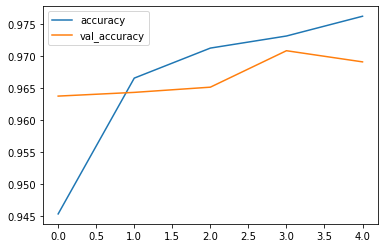

In [12]:
import pandas as pd
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot()

## Predict the Sample Image

In [32]:
img = cv2.imread('sample_image.jpg', cv2.IMREAD_COLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

array = cv2.resize(img, (img_width, img_height))
array = array / 255
array.shape

(299, 299, 3)

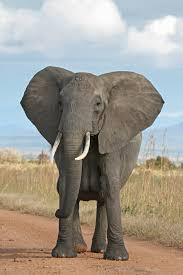

In [40]:
load_img('sample_image.jpg')

In [33]:
pred_Y = new_model.predict(np.array([array]))
pred_Y

array([[1.5772946e-08, 4.4377214e-11, 1.0000000e+00, 1.3102515e-09,
        1.5290323e-11, 1.5569646e-10, 2.9256621e-11, 3.9886394e-10,
        5.5346894e-10, 3.1634854e-11]], dtype=float32)

In [43]:
print(f'The picture is predicted as: {dirs[np.argmax(pred_Y)]}')

The picture is predicted as: elefante
